In [407]:
#export
from dataclasses import dataclass
from functools import reduce, partial
import torch
from torch import optim
from nbs.dl2.exp.nb_02 import getMnistData, assertNearZero
from nbs.dl2.exp.nb_03 import Dataset, createDataLoaders, accuracy
from nbs.dl2.exp.nb_04 import DataBunch
from nbs.dl2.exp.nb_05 import aggregateSchedulers, createCosineSchedulers, cosineScheduler
from nbs.dl2.exp.nb_06 import normalizeVectors, createBetterConvolutionModel
from nbs.dl2.exp.nb_07D import *

In [408]:
%matplotlib inline


In [409]:
xTraining, yTraining, xValidation, yValidation = getMnistData()
xTrainingNormalized, xValidationNormalized = \
    normalizeVectors(xTraining, xValidation)

In [410]:
assertNearZero(xTrainingNormalized.mean())
assertNearZero(xValidationNormalized.mean())
assertNearZero(1 - xTrainingNormalized.std())
assertNearZero(1 - xValidationNormalized.std())


In [411]:
layerSizes = [8, 16, 32, 64, 64]
numberOfClasses = 10
hiddenLayerSize = 75
batchSize = 64

In [412]:
trainingDataSet, validationDataSet = Dataset(xTrainingNormalized[:10000], yTraining[:10000]), Dataset(xValidationNormalized[:10000], yValidation[:10000])
trainingDataLoader, validationDataLoader = createDataLoaders(trainingDataSet, validationDataSet, batchSize)
imageDataBunch = DataBunch(trainingDataLoader, validationDataLoader, numberOfClasses)

In [413]:
class ProcessCancellationException(Exception): pass

In [414]:
def composeFunctions(funInput, functions): 
    return reduce(lambda accum, function: function(accum), 
                  functions, 
                  funInput)

In [415]:
result = composeFunctions(0, [
    lambda x: x + 1,
    lambda x: x + 2,
    lambda x: x + 3,
])

assert result == 6, "Composition is wrong"

In [416]:
@dataclass
class HyperParameters:
    learningRate: float = 1e-1
    weightDecay: float = 0.
    momentum: float = 0.9
    momentumSquared: float = 0.999
    epsilon: float = 1e-6

In [417]:
#export
def flatMap(function, items):
    return reduce(lambda accum, manyItems: accum + manyItems,
           list(map(function, items)))

In [418]:
result = flatMap(lambda n: list(map(lambda _: n+1, range(n+1))), 
        list(range(3)))

assert result == [1, 2, 2, 3, 3, 3], "Flat map did not work"


In [419]:
class OptimizationFunction:
    
    def __call__(self, 
                 modelLayer, 
                 hyperParameters: HyperParameters):
        return hyperParameters
    
class LearningRateAnnealer(OptimizationFunction):
    def __init__(self, learningRateSupplier)-> None:
        self._learningRateSupplier = learningRateSupplier
        
    def __call__(self, modelLayer, hyperParameters: HyperParameters):
        hyperParameters.learningRate = self._learningRateSupplier()
        return super().__call__(modelLayer, hyperParameters)
    
class LearningRateOptimizer(OptimizationFunction):
    def __call__(self, 
                 modelLayer, 
                 hyperParameters: HyperParameters):
        modelLayer.data.add_(-hyperParameters.learningRate, modelLayer.grad.data)
        return super().__call__(modelLayer, hyperParameters)
    
class StateCreator:
    def __init__(self, stateName, stateCreator)-> None:
        super().__init__()
        self.stateName = stateName
        self._stateCreator = stateCreator
        
    def __call__(self, model, hyperParameters):
        return self._stateCreator(model, hyperParameters)

class StatefulOptimizationFunction(OptimizationFunction):
    def __init__(self)-> None:
        super().__init__()
        self._state = {}
        
    def setUpState(self, modelLayer, hyperParameters):
        if modelLayer not in self._state:
            def _reducer(createdState, stateCreator: StateCreator):
                createdState[stateCreator.stateName]= stateCreator(modelLayer, hyperParameters)
                return createdState
            
            self._state[modelLayer] = reduce(
                _reducer,
                self._getStateCreators(),
                {}
            )
        return self._state[modelLayer]
        
            
    def _getStateCreators(self): return []
        

AVERAGE_GRADIENT = 'averageGradient'
AVERAGE_GRADIENT_SQUARED = 'averageGradientSquared'
STEP_COUNT = 'stepCount'
MOMENTUM_DAMPENING = 'momentumDampening'
MOMENTUM_DAMPENING_SQUARED = 'momentumDampeningSquared'

class AdamOptimizer(StatefulOptimizationFunction):
    
    def _getStateCreators(self):
        return [
            StateCreator(AVERAGE_GRADIENT, lambda modelLayer, _: torch.zeros_like(modelLayer.grad.data)),
            StateCreator(AVERAGE_GRADIENT_SQUARED, lambda modelLayer, _: torch.zeros_like(modelLayer.grad.data)),
            StateCreator(STEP_COUNT, lambda _, __: 0),
            StateCreator(MOMENTUM_DAMPENING, lambda _, hyperParameters: 1 - hyperParameters.momentum),
            StateCreator(MOMENTUM_DAMPENING_SQUARED, lambda _, hyperParameters: 1 - hyperParameters.momentumSquared),
        ]
    
    def __call__(self, 
                 modelLayer, 
                 hyperParameters: HyperParameters):
        modelLayerState = self.setUpState(modelLayer, hyperParameters)
        gradientDampening = modelLayerState[MOMENTUM_DAMPENING]
        gradientDampeningSquared = modelLayerState[MOMENTUM_DAMPENING_SQUARED]
        
        modelLayerState[STEP_COUNT] += 1
        layerGradients = modelLayer.grad.data
        modelLayerState[AVERAGE_GRADIENT].mul_(hyperParameters.momentum).add_(gradientDampening * layerGradients)
        modelLayerState[AVERAGE_GRADIENT_SQUARED].mul_(hyperParameters.momentumSquared).addcmul_(gradientDampeningSquared, layerGradients, layerGradients)

        stepCount = modelLayerState[STEP_COUNT]
        debiaseUno = (1 - gradientDampening**stepCount)
        debiasDeux = (1 - gradientDampeningSquared**stepCount)

        biasCorrectedGradient = modelLayerState[AVERAGE_GRADIENT]/debiaseUno
        biasCorrectedGradientSquared = modelLayerState[AVERAGE_GRADIENT_SQUARED]/debiasDeux
        modelLayer.data.addcdiv_(-hyperParameters.learningRate,
                                 biasCorrectedGradient,
                                 biasCorrectedGradientSquared.sqrt() + hyperParameters.epsilon)
                
        return super().__call__(modelLayer, hyperParameters)
    
class MomentumOptimizer(StatefulOptimizationFunction):
    
    def _getStateCreators(self):
        return [
            StateCreator(AVERAGE_GRADIENT, lambda modelLayer: torch.zeros_like(modelLayer.grad.data))
        ]
        
    def __call__(self, 
                 modelLayer, 
                 hyperParameters: HyperParameters):
        modelLayerState = self.setUpState(modelLayer)
        modelLayerState[AVERAGE_GRADIENT].mul_(hyperParameters.momentum).add_((1 - hyperParameters.momentum) * modelLayer.grad.data)
        
        modelLayer.data.add_(-hyperParameters.learningRate, modelLayerState[AVERAGE_GRADIENT])
        return super().__call__(modelLayer, hyperParameters)

## LAMB Notes: 

It looks like lamb performs weight decay at the last step of the it's algorithm.

$φ$ pronounced "Phi" and is a scaling function

I had to remember that the pythagorean theorem gives me the length of a two dimensional vector

In [420]:
thingo = torch.tensor([1., 2.])

thingo.norm(), thingo.pow(2).mean().sqrt()

(tensor(2.2361), tensor(1.5811))

In [421]:
class LambOptimizer(StatefulOptimizationFunction):
    
    def _getStateCreators(self):
        return [
            StateCreator(AVERAGE_GRADIENT, lambda modelLayer, _: torch.zeros_like(modelLayer.grad.data)),
            StateCreator(AVERAGE_GRADIENT_SQUARED, lambda modelLayer, _: torch.zeros_like(modelLayer.grad.data)),
            StateCreator(STEP_COUNT, lambda _, __: 0),
            StateCreator(MOMENTUM_DAMPENING, lambda _, hyperParameters: 1 - hyperParameters.momentum),
            StateCreator(MOMENTUM_DAMPENING_SQUARED, lambda _, hyperParameters: 1 - hyperParameters.momentumSquared),
        ]
    
    def __call__(self, 
                 modelLayer, 
                 hyperParameters: HyperParameters):
        modelLayerState = self.setUpState(modelLayer, hyperParameters)
        gradientDampening = modelLayerState[MOMENTUM_DAMPENING]
        gradientDampeningSquared = modelLayerState[MOMENTUM_DAMPENING_SQUARED]
        
        modelLayerState[STEP_COUNT] += 1
        layerGradients = modelLayer.grad.data
        modelLayerState[AVERAGE_GRADIENT].mul_(hyperParameters.momentum).add_(gradientDampening * layerGradients)
        modelLayerState[AVERAGE_GRADIENT_SQUARED].mul_(hyperParameters.momentumSquared).addcmul_(gradientDampeningSquared, layerGradients, layerGradients)

        stepCount = modelLayerState[STEP_COUNT]
        debiaseUno = (1 - gradientDampening**stepCount)
        debiasDeux = (1 - gradientDampeningSquared**stepCount)
        
        biasCorrectedGradient = modelLayerState[AVERAGE_GRADIENT]/debiaseUno
        biasCorrectedGradientSquared = modelLayerState[AVERAGE_GRADIENT_SQUARED]/debiasDeux
        ratioOfGraidents = biasCorrectedGradient / (biasCorrectedGradientSquared.sqrt() + hyperParameters.epsilon)
        
        s = ratioOfGraidents + hyperParameters.weightDecay * modelLayer.data
        
        layerLength = modelLayer.data.norm()
        sLength = s.norm()
        
        modelLayer.data.add_(-hyperParameters.learningRate * (layerLength/sLength), s)
                
        return super().__call__(modelLayer, hyperParameters)


** Weight Decay** is useful when you are having issues with over fitting the training data as the batches go on.
Added weight decay makes the parameter weights smaller so they learn less, but the can generalize better.

In [422]:
class WeightDecayOptimizer(OptimizationFunction):
    def __call__(self, 
                 modelLayer, 
                 hyperParameters: HyperParameters):
        modelLayer.data.mul_(1 - hyperParameters.learningRate * hyperParameters.weightDecay)
        return super().__call__(modelLayer, hyperParameters)

In [423]:
class Optimizer:
    def __init__(self, modelParameters, 
                 optimizationFunctions,
                 hyperParameters: HyperParameters=HyperParameters(learningRate=0.5)):
        super().__init__()
        self._modelParameters = list(modelParameters)
        self._hyperParameters = [hyperParameters for _ in self._modelParameters]
        self._optimizationFunctions = optimizationFunctions
        
    def getLayersWithGradients(self):
        return list(filter(lambda modelAndHyperParameters: modelAndHyperParameters[0].grad is not None, 
                           zip(self._modelParameters, self._hyperParameters)))
    
    def resetGradients(self):
        for modelParameter, _ in self.getLayersWithGradients():
            modelParameter.grad.detach_()
            modelParameter.grad.zero_()
    
    def optimizeModel(self):
        for modelParameter, hyperParameter in self.getLayersWithGradients():
            composeFunctions(hyperParameter, 
                             map(lambda fun: partial(fun, modelParameter), 
                                 self._optimizationFunctions))

In [424]:
convolutionalModelSR2 = createBetterConvolutionModel(numberOfClasses, layerSizes)

In [425]:
optimus = Optimizer(convolutionalModelSR2.parameters(), [])
len(optimus.getLayersWithGradients())

0

In [426]:
loss = torch.nn.functional.cross_entropy(convolutionalModelSR2(xTrainingNormalized), yTraining)
loss.backward()
len(optimus.getLayersWithGradients())

12

In [427]:
class LearningRateRecorder:
    def __init__(self, 
                 learningRateSupplier=lambda:0.5):
        super().__init__()
        self._aggregatedLearningRates = []
        self._learningRateSupplier = learningRateSupplier
    def __call__(self):
        learningRateReturned = self._learningRateSupplier()
        self._aggregatedLearningRates.append(learningRateReturned)
        return learningRateReturned
    
    def plotLearningRates(self):
        plotter.plot(self._aggregatedLearningRates)

## **Important Note**: PyTorch will NOT put the gradients on the parameters until backwards has been called on the model    

That is all

In [428]:
class TrainingSubscriber(StatisticsSubscriber, 
                         HookedSubscriber):

    def __init__(self,
                 lossFunction=torch.nn.functional.cross_entropy,
                 schedulingFunction=cosineScheduler(1e-1, 1e-6), 
                 optimizationFunctions=[]
                 ):
        super().__init__(name="Training")
        self._optimizer: Optimizer = None
        self._optimizationFunctions = optimizationFunctions
        self._schedulingFunction = schedulingFunction
        self._lossFunction = lossFunction
        
        self._learningRateRecorder = LearningRateRecorder()
        
    def plotLearningRate(self):
        self._learningRateRecorder.plotLearningRates()
        
    def getOptimizationFunctions(self):
        learningRateSupplier = lambda: self._schedulingFunction(self.calculateCurrentProgress())
        self._learningRateRecorder = LearningRateRecorder(learningRateSupplier )
        return [
            # WeightDecayOptimizer(),
            LearningRateAnnealer(self._learningRateRecorder),
            
            # AdamOptimizer(), # does not play well with others! see notes above
            
            LambOptimizer(),
            
            # MomentumOptimizer(),
            # LearningRateOptimizer()
            
        ]

    def preModelTeach(self, model, epochs):
        super().preModelTeach(model, epochs)
        self._optimizer = Optimizer(model.parameters(), 
                                    self.getOptimizationFunctions(),
                                    HyperParameters(
                                        weightDecay=0.01,
                                        learningRate=self._schedulingFunction(0)
                                    ))
        self._totalEpochs = epochs

    def postBatchEvaluation(self, predictions, validationData):
        super().postBatchEvaluation(predictions, validationData)
        calculatedLoss = self._lossFunction(predictions, validationData)
        self._teachModel(calculatedLoss)
        self.postBatchLossConsumption(calculatedLoss)

    def _teachModel(self, loss):
        loss.backward() # adds auto gradients to model parameters
        self._optimizer.optimizeModel()
        self._optimizer.resetGradients() 

In [429]:
class TeacherOptimized:
    def __init__(self,
                 dataBunch,
                 trainingSubscriber: TrainingSubscriber,
                 validationSubscriber: ValidationSubscriber):
        self._dataBunch = dataBunch
        self._trainingSubscriber = trainingSubscriber
        self._validationSubscriber = validationSubscriber

    def teachModel(self, model, numberOfEpochs):
        self._notifiyPreTeach(model, numberOfEpochs)
        for epoch in range(numberOfEpochs):
            self._trainModel(model,
                             epoch)
            self._validateModel(model,
                                epoch)
        self._notifiyPostTaught()

    def _notifiyPreTeach(self, model, epochs):
        self._trainingSubscriber.preModelTeach(model, epochs)
        self._validationSubscriber.preModelTeach(model, epochs)

    def _notifiyPostTaught(self):
        self._trainingSubscriber.postModelTeach()
        self._validationSubscriber.postModelTeach()

    def _trainModel(self, model, epoch):
        self._processData(model,
                          self._dataBunch.trainingDataSet,
                          epoch,
                          self._trainingSubscriber)

    def _validateModel(self, model, epoch):
        with torch.no_grad():
            self._processData(model,
                              self._dataBunch.validationDataSet,
                              epoch,
                              self._validationSubscriber)

    def _processData(self,
                     model,
                     dataLoader,
                     epoch,
                     processingSubscriber: Subscriber):
        processingSubscriber.preEpoch(epoch, dataLoader)
        try:
            for _xDataBatch, _yDataBatch in dataLoader:
                processingSubscriber.preBatchEvaluation()
                _predictions = model(_xDataBatch)
                processingSubscriber.postBatchEvaluation(_predictions, _yDataBatch)
        except ProcessCancellationException: pass
        finally:
            processingSubscriber.postEpoch(epoch)


In [430]:
#export
def createCosineScheduler(start, high, end):
    return [cosineScheduler(start, high), cosineScheduler(high, end)]

def createWeightAndBiasSchedulers(weightsRanges=(0.3, 0.6, 0.2)):
    phases = [0.3, 0.7]
    _weightsScheduler = aggregateSchedulers(phases, createCosineScheduler(*weightsRanges)) 
    _biasScheduler = aggregateSchedulers(phases, createCosineScheduler(0.9, 1.8, 0.6))
    return _weightsScheduler, _biasScheduler

In [431]:
validationSubscriber = ValidationSubscriber()


In [432]:
weightScheduler, biasScheduler = createWeightAndBiasSchedulers()

## AdaM Notes

Adam likes to have smaller learning rates somewhere around 1e-3.
The current default weights scheduler is too high for Adam.

Adam: Adaptive Moment Estimation

> Some of Adam’s advantages are that the magnitudes of parameter updates are invariant to
rescaling of the gradient, its stepsizes are approximately bounded by the stepsize hyperparameter,
it does not require a stationary objective, it works with sparse gradients, and it naturally performs a
form of step size annealing.

## it naturally performs a form of step size annealing

In [433]:
adamWeightScheduler, adamBiasScheduler = createWeightAndBiasSchedulers((1e-3, 1e-3, 2e-6))
lambWeightScheduler, lambBiasScheduler = createWeightAndBiasSchedulers((1e-2, 1e-2, 2e-6))

In [434]:
trainingSubscriber = TrainingSubscriber(schedulingFunction=lambWeightScheduler)

In [435]:
teacher = TeacherEnhanced(imageDataBunch, 
                          trainingSubscriber,
                          validationSubscriber
                         )


In [436]:
convolutionalModelSR1 = createBetterConvolutionModel(numberOfClasses, layerSizes)


In [437]:
accuracy(convolutionalModelSR1(validationDataSet.xVector), validationDataSet.yVector)

tensor(0.1090)

In [438]:
teacher.teachModel(convolutionalModelSR1, 3)

Epoch #0 Training: Loss 1.1911877393722534 Accuracy 0.5921576619148254
Epoch #0 Validation: Loss 0.0 Accuracy 0.9257317781448364
Epoch #1 Training: Loss 0.18075241148471832 Accuracy 0.9452627301216125
Epoch #1 Validation: Loss 0.0 Accuracy 0.9613330960273743
Epoch #2 Training: Loss 0.0767051950097084 Accuracy 0.9775079488754272
Epoch #2 Validation: Loss 0.0 Accuracy 0.9740902185440063


In [439]:
accuracy(convolutionalModelSR1(validationDataSet.xVector), validationDataSet.yVector)

tensor(0.9738)

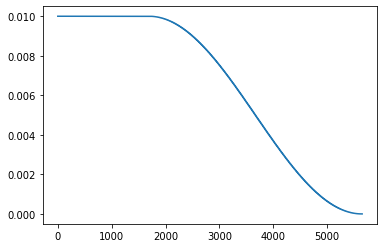

In [440]:
trainingSubscriber.plotLearningRate()

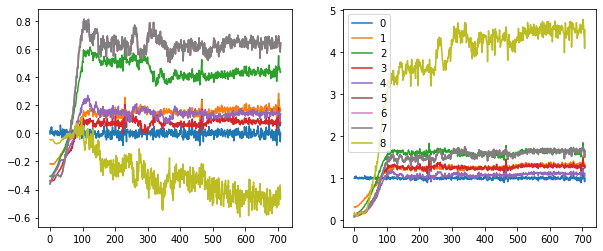

In [441]:
trainingSubscriber.plotMeansAndStandardDeviations()

## Todo: 


## Things to look at later

- Learning Rate Capping
- Bias Learning rate annealing
